In [1]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib
import matplotlib.pyplot as plt
from pyomo.opt import SolverFactory
import time


## First battery arbitrage example

- Read the load file
- Assign a cost per kW for battery and time-varying cost for load
- Minimize the cost, record the battery power.
- Plot

In [2]:
load = pd.read_csv('Test_load.csv', delimiter = ';')[3:] #assign the csv file to the dataframe and disregard the first 3 row
load = load.reset_index(drop=True)                              #re-assign the index value
load.columns = ['Data','Power']                          #rename the columns
load["Data"]=pd.date_range("01/01/2022 00:00", periods=8760, freq='h') #to put the values in an according date time
load["Power"]=pd.to_numeric(load.Power)                  #convert the power values into float
load = load.fillna(0)

load =load[:720]

index = list(load.index.values)    #assign a list for variable, each index is a variable namepd.renameload.columns[1] = "Load"
load_value = load['Power'].values


#-------Adding a time varying tariff-----------
load['Tariff'] = [0.14 if (12 <= time.hour <=18)   else
                     0.1 if ( (8<= time.hour <= 12) | (18 <= time.hour <= 22))  else
                     0.08 for time in load['Data']]
#-------for simplicity only; in the future the tariff should be mapped from another dataframe
                             
BattCost = 314.2                          #per KWH
InverterCost = 65.6                       #per KW

#--------Pyomo implementation---------------------
model = pyo.ConcreteModel()

#set the bounds for battery power
ub = max(load['Power'])
lb = -ub
#set variables
model.Pbatt = pyo.Var(index, bounds= (lb, ub))
model.Pmax = pyo.Var(bounds= (0,ub)) 
model.Qmax = pyo.Var()
#set objective
cost = load['Tariff'].values
model.objective = pyo.Objective(expr = sum((load_value[i]+model.Pbatt[i])*cost[i] for i in index) + (BattCost*model.Qmax + InverterCost*model.Pmax)/(20*12), sense= pyo.minimize)

#set constraints
model.Constraint = pyo.ConstraintList()
for i in index:
    print(load_value[i])
    model.Constraint.add( expr = model.Pbatt[i] - load_value[i] <= 0) #load constraint
    model.Constraint.add( expr = model.Pbatt[i] - model.Pmax  <= 0 ) #Pmax constraint
    model.Constraint.add( expr = model.Pbatt[i] + model.Pmax  >= 0 )#Pmin constraint
    model.Constraint.add( expr = model.Pbatt[i] + load_value[i] <= ub )#Total load constraint

 #   model.Constraint.add( expr = model.Pbatt[i] - model.Qmax <= 0 )#Qmax constraint
#  model.Constraint.add( expr = model.Pbatt[i] + model.Qmax >= 0 )#Qmax constraint

    model.Constraint.add( expr = model.Qmax + sum([model.Pbatt[j]*1 for j in range(i)]) - model.Qmax <= 0 )#Qmax constraint
    model.Constraint.add( expr = model.Qmax + sum([model.Pbatt[j]*1 for j in range(i)]) - 0.2*model.Qmax >= 0) #Qmin constraint
    
#print the model
#model.pprint()
    

216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
203.5898294
203.5898294
115.2698294
405.5859709
405.5859709
439.3282344
439.3282344
442.2909265
447.567648
447.567648
447.567648
447.567648
480.1465367
277.8340784
277.8340784
277.8340784
277.8340784
277.8340784
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
203.5898294
203.5898294
115.2698294
405.5859709
405.5859709
439.3282344
439.3282344
442.2909265
447.567648
447.567648
447.567648
447.567648
480.1465367
277.8340784
277.8340784
277.8340784
277.8340784
277.8340784
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
203.5898294
203.5898294
115.2698294
405.5859709
405.5859709
439.3282344
439.3282344
442.2909265
447.567648
447.567648
447.567648
447.567648
480.1465367
277.8340784
277.8340784
277.8340784
277.8340784
277.8340784
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
203.5898294
203.5898294
115.2698294
405.5859709
405.5859709
439.3282344
439.3282344
442.

In [3]:
#Solve the model
SolverFactory('cbc').solve(model)
print(pyo.value(model.Pmax))
print(pyo.value(model.Qmax))
#print(pyo.value(model.Pbatt[i]) for i in index)
#solution = [int(pyo.value(model.x[i])) for i in indici]
#data['solution'] = solution

260.27637
2277.4182


In [4]:

load['BESS'] = [int(pyo.value(model.Pbatt[i])) for i in index]
print( sum((load_value[i])*cost[i] for i in index))
print( sum((load_value[i]+load['BESS'][i])*cost[i] for i in index))
print(load[24:48])


25336.414071959978
21880.89407196004
                  Data       Power  Tariff  BESS
24 2022-01-02 00:00:00  216.580845    0.08   216
25 2022-01-02 01:00:00  216.580845    0.08   216
26 2022-01-02 02:00:00  216.580845    0.08   216
27 2022-01-02 03:00:00  216.580845    0.08   216
28 2022-01-02 04:00:00  216.580845    0.08   216
29 2022-01-02 05:00:00  203.589829    0.08   203
30 2022-01-02 06:00:00  203.589829    0.08   203
31 2022-01-02 07:00:00  115.269829    0.08   115
32 2022-01-02 08:00:00  405.585971    0.10  -156
33 2022-01-02 09:00:00  405.585971    0.10    74
34 2022-01-02 10:00:00  439.328234    0.10    40
35 2022-01-02 11:00:00  439.328234    0.10    40
36 2022-01-02 12:00:00  442.290927    0.14  -260
37 2022-01-02 13:00:00  447.567648    0.14  -260
38 2022-01-02 14:00:00  447.567648    0.14  -260
39 2022-01-02 15:00:00  447.567648    0.14  -260
40 2022-01-02 16:00:00  447.567648    0.14  -260
41 2022-01-02 17:00:00  480.146537    0.14  -260
42 2022-01-02 18:00:00  277.8340

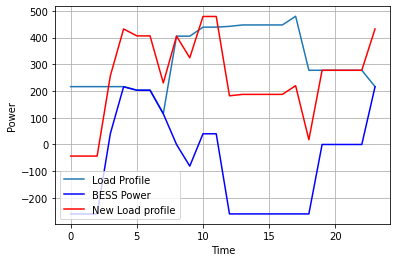

In [27]:
time1 = 0
time2 = 24
timeframe =[]
for time in load['Data']:
    timeframe.append(time.hour)
    
plt.plot(load.index[time1:time2], load.Power[time1:time2], label='Load Profile')
plt.plot(load.index[time1:time2], load.BESS[time1:time2], '-b', label='BESS Power')
plt.plot(load.index[time1:time2],load.Power[time1:time2] + load.BESS[time1:time2], '-r', label='New Load profile')
plt.grid(True)
#plt.fill_between(df.Data[a:b], df['Power'][a:b], df['NP'][a:b], where=df['Power'][a:b] >= df['NP'][a:b],facecolor='green', alpha=0.2, interpolate=True, label='Discharging')
#plt.fill_between(df.Data[a:b], df['Power'][a:b], df['NP'][a:b], where=df['Power'][a:b] <= df['NP'][a:b],facecolor='red', alpha=0.2, interpolate=True, label='Charging')
plt.xlabel("Time")
plt.ylabel("Power")
#plt.title()
plt.legend()
plt.show()

In [20]:
print(ub)

480.1465367


## Power Smoothing Example

- Read the load file
- Assign a cost per kW for battery and dynamic cost for load
- Minimize the cost, record the battery power.
- Plot

In [2]:
load = pd.read_csv('Test_load.csv', delimiter = ';')[3:] #assign the csv file to the dataframe and disregard the first 3 row
load = load.reset_index(drop=True)                              #re-assign the index value
load.columns = ['Data','Power']                          #rename the columns
load["Date"]=pd.date_range("01/01/2022 00:00", periods=8760, freq='h') #to put the values in an according date time
load["Power"]=pd.to_numeric(load.Power)                  #convert the power values into float
load = load.fillna(0)

load =load[:168]

index = list(load.index.values)    #assign a list for variable, each index is a variable namepd.renameload.columns[1] = "Load"
load_value = load['Power'].values


In [3]:
maxload = load.groupby([load['Date'].dt.date])['Power'].max()
maxload_value = list(maxload)




In [14]:


#-------Adding a dynamic tariff-----------
kWhCost = 0.0938
kWCost  = 0.0702

#-------for simplicity only; in the future the tariff should be mapped from another dataframe
                             
BattCost = 314.2/3                          #per KWH
InverterCost = 65.6/3                       #per KW

#--------Pyomo implementation---------------------
model = pyo.ConcreteModel()

#set the bounds for battery power
ub = max(load['Power'])
lb = -ub
#set variables
model.Pbatt = pyo.Var(index, bounds= (lb, ub))
model.Pmax = pyo.Var(bounds= (0,ub)) 
model.Qmax = pyo.Var()
#set objective
#cost = load['Tariff'].values
model.objective = pyo.Objective(expr = sum((load_value[i]+model.Pbatt[i])*kWhCost for i in index)
                                + sum((j - model.Pmax)*kWCost for j in maxload_value)
                                + (BattCost*model.Qmax + InverterCost*model.Pmax)/(20*12*4), sense= pyo.minimize)

#set constraints
model.Constraint = pyo.ConstraintList()
for i in index:
    print(load_value[i])
    model.Constraint.add( expr = model.Pbatt[i] - load_value[i] <= 0) #load constraint
    model.Constraint.add( expr = model.Pbatt[i] - model.Pmax  <= 0 ) #Pmax constraint
    model.Constraint.add( expr = model.Pbatt[i] + model.Pmax  >= 0 )#Pmin constraint
    model.Constraint.add( expr = model.Pbatt[i]*1 - model.Qmax <=0) #Q max constraint
    model.Constraint.add( expr = model.Pbatt[i] + load_value[i] + model.Pmax <= ub) #load constraint for the designated peak load

 #   model.Constraint.add( expr = model.Pbatt[i] - model.Qmax <= 0 )#Qmax constraint
#  model.Constraint.add( expr = model.Pbatt[i] + model.Qmax >= 0 )#Qmax constraint

    model.Constraint.add( expr = model.Qmax + sum([model.Pbatt[j]*1 for j in range(i)]) - model.Qmax <= 0 )#Qmax constraint
    model.Constraint.add( expr = model.Qmax + sum([model.Pbatt[j]*1 for j in range(i)]) - 0.2*model.Qmax >= 0) #Qmin constraint
    
#print the model
#model.pprint()
    

216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
203.5898294
203.5898294
115.2698294
405.5859709
405.5859709
439.3282344
439.3282344
442.2909265
447.567648
447.567648
447.567648
447.567648
480.1465367
277.8340784
277.8340784
277.8340784
277.8340784
277.8340784
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
203.5898294
203.5898294
115.2698294
405.5859709
405.5859709
439.3282344
439.3282344
442.2909265
447.567648
447.567648
447.567648
447.567648
480.1465367
277.8340784
277.8340784
277.8340784
277.8340784
277.8340784
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
203.5898294
203.5898294
115.2698294
405.5859709
405.5859709
439.3282344
439.3282344
442.2909265
447.567648
447.567648
447.567648
447.567648
480.1465367
277.8340784
277.8340784
277.8340784
277.8340784
277.8340784
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
216.5808449
203.5898294
203.5898294
115.2698294
405.5859709
405.5859709
439.3282344
439.3282344
442.

In [15]:
#Solve the model
SolverFactory('cbc').solve(model)
print(pyo.value(model.Pmax))
print(pyo.value(model.Qmax))
#print(pyo.value(model.Pbatt[i]) for i inindex
#solution = [int(pyo.value(model.x[i])) for i in indici]
#data['solution'] = solution

159.14211
1490.6153


In [16]:

load['BESS'] = [int(pyo.value(model.Pbatt[i])) for i in index]
#print( sum((load_value[i])*cost[i] for i in index))
#print( sum((load_value[i]+load['BESS'][i])*cost[i] for i in index))
print(load[24:48])

          Data       Power                Date  BESS
24  1641078000  216.580845 2022-01-02 00:00:00   104
25  1641081600  216.580845 2022-01-02 01:00:00   104
26  1641085200  216.580845 2022-01-02 02:00:00   104
27  1641088800  216.580845 2022-01-02 03:00:00   104
28  1641092400  216.580845 2022-01-02 04:00:00   104
29  1641096000  203.589829 2022-01-02 05:00:00   117
30  1641099600  203.589829 2022-01-02 06:00:00   117
31  1641103200  115.269829 2022-01-02 07:00:00   115
32  1641106800  405.585971 2022-01-02 08:00:00   -84
33  1641110400  405.585971 2022-01-02 09:00:00   -84
34  1641114000  439.328234 2022-01-02 10:00:00  -118
35  1641117600  439.328234 2022-01-02 11:00:00  -118
36  1641121200  442.290927 2022-01-02 12:00:00  -121
37  1641124800  447.567648 2022-01-02 13:00:00  -126
38  1641128400  447.567648 2022-01-02 14:00:00  -126
39  1641132000  447.567648 2022-01-02 15:00:00  -126
40  1641135600  447.567648 2022-01-02 16:00:00  -126
41  1641139200  480.146537 2022-01-02 17:00:00

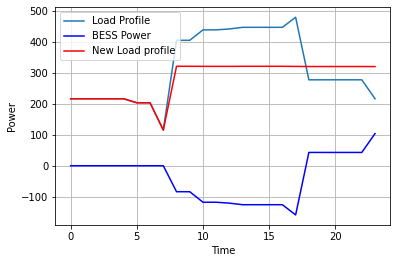

In [17]:
time1 = 0
time2 = 24
timeframe =[]
for time in load['Date']:
    timeframe.append(time.hour)
    
plt.plot(load.index[time1:time2], load.Power[time1:time2], label='Load Profile')
plt.plot(load.index[time1:time2], load.BESS[time1:time2], '-b', label='BESS Power')
plt.plot(load.index[time1:time2],load.Power[time1:time2] + load.BESS[time1:time2], '-r', label='New Load profile')
plt.grid(True)
#plt.fill_between(df.Data[a:b], df['Power'][a:b], df['NP'][a:b], where=df['Power'][a:b] >= df['NP'][a:b],facecolor='green', alpha=0.2, interpolate=True, label='Discharging')
#plt.fill_between(df.Data[a:b], df['Power'][a:b], df['NP'][a:b], where=df['Power'][a:b] <= df['NP'][a:b],facecolor='red', alpha=0.2, interpolate=True, label='Charging')
plt.xlabel("Time")
plt.ylabel("Power")
#plt.title()
plt.legend()
plt.show()

## Example abstract model

model = pyo.AbstractModel()

model.m = pyo.Param(within=pyo.NonNegativeIntegers)
model.n = pyo.Param(within=pyo.NonNegativeIntegers)

model.I = pyo.RangeSet(1, model.m)
model.J = pyo.RangeSet(1, model.n)

model.a = pyo.Param(model.I, model.J)
model.b = pyo.Param(model.I)
model.c = pyo.Param(model.J)

#the next line declares a variable indexed by the set J: x
model.x = pyo.Var(model.J, domain=pyo.NonNegativeReals)

def obj_expression(m):
    return pyo.summation(m.c, m.x)

model.OBJ = pyo.Objective(rule=obj_expression)

def ax_constraint_rule(m,i):
    #return th eexpression for the constraint for i
    return sum(m.a[i,j] * m.x[j] for j in m.J) >= m.b[i]

#the next line crates one constraint for each member of the set model. I
model.AxbConstraint = pyo.Constraint(model.I, rule=ax_constraint_rule)



In abstract models, Pyomo expressions are usually provided to objective and constraint declarations via a function defined with a Python def statement. The def statement establishes a name for a function along with its arguments. When Pyomo uses a function to get objective or constraint expressions, it always passes in the model (i.e., itself) as the the first argument so the model is always the first formal argument when declaring such functions in Pyomo. Additional arguments, if needed, follow

## Non-Continuous Objectives

model = ConcreteModel()
model.x= Var(domain=NonNegativeReals)
model.y= Var(domain=NonNegativeReals)
model.z= Var(domain=NonNegativeReals)

model.profit= Objective(expr= 40*model.x + 30*model.y + 50*model.z, sense=maximize)
model.demand = Constraint(expr= model.x <= 40)
model.laborA = Constraint(expr= model.x + model.y <=80)
model.laborB = Constraint(expr= 2*model.x + model.z <=100)
model.laborC = Constraint(expr = model.z <=50)

#solve
SolverFactory('cbc').solve(model).write()

print(f"Profit = ${model.profit()}")
print(f"X = {model.x()} units")
print(f"Y = {model.y()} units")
print(f"Z = {model.z()} units")

M = 100

model = ConcreteModel()

model.x = Var(domain=NonNegativeReals)

model.y = Var(domain=NonNegativeReals)
model.y0= Var(bounds=(0, 20))
model.y1= Var(domain=NonNegativeReals)
model.by= Var(domain=Binary)

model.z = Var(domain=NonNegativeReals)
model.z0= Var(bounds=(0, 30))
model.z1= Var(domain=NonNegativeReals)
model.bz= Var(domain=Binary)
             
model.profit= Objective(sense=maximize, expr = 40*model.x + 30*model.y0 + 50*model.y1 + 600*model.by + 50*model.z0 + 60*model.z1 + 600*model.bz)

model.dy= Constraint(expr = model.y == model.y0 + model.y1)
model.dz= Constraint(expr = model.z == model.z0 + model.z1)
              
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.z <= 100)
model.laborC = Constraint(expr = model.z <= 50)

model.bonus_y0 = Constraint(expr = model.y0 >=20 -M*(1-model.by))
model.bonus_z0 = Constraint(expr = model.z0 >=30 -M*(1-model.bz))
model.bonus_y1 = Constraint(expr = model.y1 <= M*model.by)
model.bonus_z1 = Constraint(expr = model.z1 <= M*model.bz)

SolverFactory ('cbc').solve(model).write()
                        

print(f"Profit = ${model.profit()}")
print(f"X = {model.x()} units")
print(f"Y = {model.y0()} + {model.y1()} = {model.y()} units  {model.by()}")
print(f"Z = {model.z0()} + {model.z1()} = {model.z()} units  {model.bz()}")

## Linear blending problem

data = {
    'A': {'abc': 0.045, 'cost': 0.32},
    'B': {'abc': 0.037, 'cost': 0.25},
    'W': {'abc': 0.000, 'cost': 0.05},
}

vol=100
abv=0.040

def beer_blend(vol, abv, data):
    C= data.keys()
    model = pyomo.ConcreteModel()
    model.x=pyomo.Var(C, domain=pyomo.NonNegativeReals)
    model.cost=pyomo.Objective(expr=sum(model.x[c]*data[c]['cost'] for c in C))
    model.vol=pyomo.Constraint(expr= vol == sum(model.x[c] for c in C))
    
    solver=pyomo.SolverFactory('cbc')
    solver.solve(model)
    
    print('Optimal Blend')
    for c in data.keys():
        print(' ', c, ':', model.x[c](), 'gallons')
    print()
    print('Volume= ', model.vol(), 'gallons')
    print('Cost = $', model.cost())
beer_blend(vol, abv, data)

## Simple production models with linear constraint

model= ConcreteModel()

#declare decision variables
model.x=Var(domain=NonNegativeReals)
model.y=Var(domain=NonNegativeReals)

#declare objective
model.profit = Objective(
    expr= 40*model.x +30*model.y,
    sense=maximize)

#declare constraints
model.demand = Constraint(expr=model.x <= 40)
model.laborA = Constraint(expr=(model.x + model.y) <= 80)
model.laborB = Constraint(expr=(2*model.x + model.y) <= 100)

#solve
SolverFactory('cbc').solve(model).write()

model.profit.display()
model.x.display()

print(f"Profit = {model.profit()} per week")
print(f"X = {model.x()} units per week")
print(f"Y = {model.y()} units per week")

print("\nSolution")
print(f"x = {model.x()}")
print(f"y = {model.y()}")

print("\nSensitivity Analysis")
print(f"y_demand = {-model.dual[model.demand]}")
print(f"y_laborA = {-model.dual[model.laborA]}")
print(f"y_laborB = {-model.dual[model.laborB]}")

## Warehouse models

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect('equal')
ax.axis([0, 100, 0, 100])
ax.set_xlabel('X Production')
ax.set_ylabel('Y Production')

# Labor A constraint
x = np.array([0, 80])
ax.plot(x, 80 - x, 'r', lw=2)

# Labor B constraint
x = np.array([0, 50])
ax.plot(x, 100 - 2*x, 'b', lw=2)

# Demand constraint
ax.plot([40, 40], [0, 100], 'g', lw=2)

ax.legend(['Labor A Constraint', 'Labor B Constraint', 'Demand Constraint'])
ax.fill_between([0, 80, 100], [80, 0,0 ], [100, 100, 100], color='r', alpha=0.15)
ax.fill_between([0, 50, 100], [100, 0, 0], [100, 100, 100], color='b', alpha=0.15)
ax.fill_between([40, 100], [0, 0], [100, 100], color='g', alpha=0.15)

# Contours of constant profit
x = np.array([0, 100])
for p in np.linspace(0, 3600, 10):
    y = (p - 40*x)/30
    ax.plot(x, y, 'y--')
    
arrowprops = dict(shrink=.1, width=1, headwidth=5)

# Optimum
ax.plot(20, 60, 'r.', ms=20)
ax.annotate('Mixed Product Strategy', xy=(20, 60), xytext=(50, 70), arrowprops=arrowprops)

ax.plot(0, 80, 'b.', ms=20)
ax.annotate('Y Only', xy=(0, 80), xytext=(20, 90), arrowprops=arrowprops)

ax.plot(40, 0, 'b.', ms=20)
ax.annotate('X Only', xy=(40, 0), xytext=(70, 20), arrowprops=arrowprops)

ax.text(4, 23, 'Increasing Profit')
ax.annotate('', xy=(20, 15), xytext=(0,0), arrowprops=arrowprops)

fname = 'LPprog01.png'
fname = os.path.join('figures', fname) if os.path.exists('figures') else fname
plt.savefig(fname, bbox_inches='tight')

#read data from excel file
df=pandas.read_excel('dataset.xlsx', header=0, index_col=0)

N=list(df.index.map(str))
M=list(df.columns.map(str))
d={(r,c):df.at[r,c] for r in N for c in M}
P=2

#create the model 
model = ConcreteModel(name="(WL)")
model.x=Var(N, M, bounds=(0,1))
model.y=Var(N, within=Binary)


def obj_rule(model):
    return sum(d[n,m]*model.x[n,m] for n in M for m in M)
model.obj= Objective(rule=obj_rule)

def one_per_cust_rule(model, m):
     return sum(model.x[n,m] for n in N)==1
model.one_per_cust=Constraint(M, rule=one_per_cust_rule)

def warehouse_active_rule(model, n, m):
    return model.x[n,m] <= model.y[n]
model.warehouse_active=Constraint(N,M, rule=warehouse_active_rule)

def num_warehouses_rule(model):
    return sum(model.y[n] for n in N) <= P
model.num_warehouses=Constraint(rule=num_warehouses_rule)

#solve the model and report the results
solver= SolverFactory('glpk')
solver.solve(model)
model.pprint()